# Locally optimal MH proposals for discrete Potts models

This notebook explores experiments with ideas from [Grathwohl et al. (2021)](https://arxiv.org/abs/2102.04509) and [Zanella (2017)](https://arxiv.org/abs/1711.07424).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
import math
from collections import Counter
from typing import Callable, Tuple

import numpy as np
import torch
import torch.distributions as dist
import pyro
import matplotlib
import matplotlib.pyplot as plt
from torch.distributions import constraints
from opt_einsum import contract as einsum
from pyro.ops.stats import autocorrelation
from pyro.distributions.testing.gof import multinomial_goodness_of_fit
from tqdm.auto import tqdm

matplotlib.rcParams.update({'figure.facecolor': "white"})
matplotlib.rcParams.update({'figure.dpi': 200})

Let's compare two of Zanella's balancing functions `g(-)`.

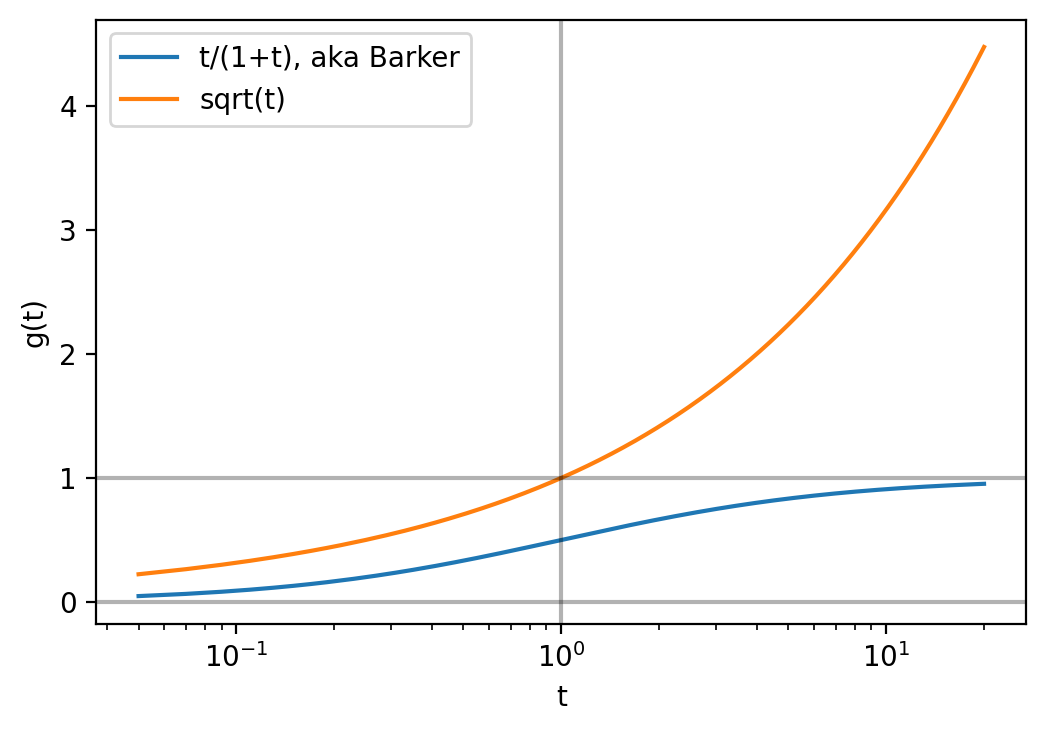

In [3]:
t = np.linspace(0.05,20,1000)
plt.plot(t, t / (1 + t), label="t/(1+t), aka Barker")
plt.plot(t, t ** 0.5, label="sqrt(t)")
plt.xlabel("t")
plt.ylabel("g(t)")
plt.xscale("log")
plt.axvline(1, color="black", alpha=0.3)
plt.axhline(0, color="black", alpha=0.3)
plt.axhline(1, color="black", alpha=0.3)
plt.legend(loc="best");

Next consider a sparse Potts distribution class, where we implement a `.log_prob_nbhd()` method for locally-informed Metropolis-Hastings sampling.

In [4]:
class OneHotCategoricalPotts(dist.Distribution):
    arg_constraints = {
        "vertex_weights": constraints.independent(constraints.real, 2),
        "edge_weights": constraints.independent(constraints.real, 3),
    }
    def __init__(
        self, vertex_weights: torch.Tensor, edge_weights: torch.Tensor, edges: torch.Tensor
    ):
        self.vertex_weights = vertex_weights
        self.edge_weights = edge_weights
        self.edges = edges
        assert edges.dim() == 2
        assert edges.shape[0] == 2
        assert all(len(set(edge)) == 2 for edge in edges.T.tolist()), "self edge"
        super().__init__(batch_shape=(), event_shape=vertex_weights.shape)

    def log_prob(self, x_onehot: torch.Tensor) -> torch.Tensor:
        """
        Returns non-normalized lob_prob.
        """
        # Note this differentiable version performs about 400x more work than
        # necessary due to the one-hot encoding. A better-engineered version
        # would hand-implement the .log_prob() and .log_prob_nbhd() methods
        # using index-encoding rather than one-hot-encoding.
        assert x_onehot.dim() >= 2
        head, tail = x_onehot[..., self.edges, :]
        return (
            einsum("...vk,vk->...", x_onehot, self.vertex_weights)
            + einsum("...ej,...ek,ejk->...", head, tail, self.edge_weights)
        )

    def log_prob_nbhd(self, x_onehot: torch.Tensor) -> torch.Tensor:
        """
        Assuming there are no self-edges (as asserted above),
        the gradient approximation of Grathwohl et al. (2021) is exact.
        """
        x_grad = x_onehot.clone().requires_grad_()
        log_prob = self.log_prob(x_grad)
        result = torch.autograd.grad(log_prob, x_grad)[0].detach()
        result -= (result * x_onehot).sum(-1, True)
        return result
    
    def enumerate_support(self):
        p, k = self.event_shape
        result = torch.zeros(k ** p, p, k)
        ks = [list(range(k))] * p
        for a, cs in enumerate(itertools.product(*ks)):
            for b, c in enumerate(cs):
                result[a, b, c] = 1
        return result

In [5]:
def random_potts(p: int=100, k: int=20, density: float=0.1):
    P = torch.arange(p)
    e = p * (p - 1) // 2
    complete_edges = torch.stack([
        P[:, None].expand(p, p), P.expand(p, p)
    ], 0).reshape(2, p * p)
    complete_edges = complete_edges[:, complete_edges[0] < complete_edges[1]]
    assert complete_edges.shape == (2, e)
    complete_edges = complete_edges[:, torch.randperm(e)]
    edges = complete_edges[:, :round(density * e)].clone()
    vertex_weights = torch.randn(p, k)
    edge_weights = torch.randn(edges.shape[1], k, k)
    return OneHotCategoricalPotts(vertex_weights, edge_weights, edges)

In [6]:
def test_enumerate_support(p, k, expected):
    actual = random_potts(p, k).enumerate_support().tolist()
    assert actual == expected
    
test_enumerate_support(
    2, 2,
    [
        [[1, 0], [1, 0]],
        [[1, 0], [0, 1]],
        [[0, 1], [1, 0]],
        [[0, 1], [0, 1]],
    ],
)
    
test_enumerate_support(
    2, 3,
    [
        [[1, 0, 0], [1, 0, 0]],
        [[1, 0, 0], [0, 1, 0]],
        [[1, 0, 0], [0, 0, 1]],
        [[0, 1, 0], [1, 0, 0]],
        [[0, 1, 0], [0, 1, 0]],
        [[0, 1, 0], [0, 0, 1]],
        [[0, 0, 1], [1, 0, 0]],
        [[0, 0, 1], [0, 1, 0]],
        [[0, 0, 1], [0, 0, 1]],
    ],
)

In [7]:
def mcmc(d: OneHotCategoricalPotts, g: callable):
    p, k = d.event_shape
    x0 = torch.zeros(p, k)
    g0 = g(d.log_prob_nbhd(x0))
    g0 -= g0.reshape(-1).logsumexp(-1)
    while True:
        # Propose.
        ij = dist.Categorical(logits=g0.reshape(-1)).sample().item()
        i, j = divmod(ij, k)
        x1 = x0.clone()
        x1[i] = 0
        x1[i, j] = 1
        
        # Accept or reject.
        g1 = g(d.log_prob_nbhd(x1))
        g1 -= g1.reshape(-1).logsumexp(-1)
        ratio = (torch.tensordot(g0, x1) - torch.tensordot(g1, x0)).exp()
        if ratio > torch.rand(()):
            x0, g0 = x1, g1  # accept
        yield x0

## Testing the sampler

Let's quick test that the sampler draws correct samples.

In [8]:
def one_hot_to_hashable(x_onehot: torch.Tensor) -> Tuple[int]:
    assert x_onehot.dim() == 2
    return tuple(x_onehot.max(-1).indices.tolist())

In [9]:
def get_histogram(n, d, g):
    hist = Counter()
    for i, x in tqdm(enumerate(mcmc(d, g)), total=n):
        hist[one_hot_to_hashable(x)] += 1
        if i >= n:
            return hist

In [10]:
N = 10000
P = 5
K = 2

pyro.set_rng_seed(20220708)
d = random_potts(P, K)
hist = get_histogram(N, d, g=torch.nn.functional.logsigmoid)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [11]:
xs = d.enumerate_support()
log_probs = {one_hot_to_hashable(x): float(d.log_prob(x)) for x in xs}
log_total = float(torch.tensor(list(log_probs.values())).logsumexp(-1))
probs_dict = {k: math.exp(v - log_total) for k, v in log_probs.items()}

In [12]:
keys = sorted(probs_dict)
probs = torch.tensor([probs_dict[k] for k in keys])
counts = torch.tensor([hist[k] for k in keys])
gof = multinomial_goodness_of_fit(probs, counts, plot=True)
print("gof =", gof)
assert gof > 0.1

    Prob    Count
   0.116     1463 ------------------------------------------------------------
   0.101     1261 ----------------------------------------------------
   0.099     1313 ------------------------------------------------------
   0.087     1069 --------------------------------------------
   0.080      926 --------------------------------------
   0.069      690 ----------------------------
   0.058      594 ------------------------
   0.049      472 -------------------
   0.047      376 ---------------
   0.041      295 ------------
   0.040      364 ---------------
   0.035      255 ----------
   0.033      221 ---------
   0.028      218 ---------
   0.023      143 ------
   0.020      128 -----
   0.009       30 -
   0.008       27 -
   0.008       38 --
   0.007       15 -
   0.006       15 -
   0.005       28 -
   0.005        8 
   0.004       13 -
   0.004       13 -
   0.003        0 
   0.003        8 
   0.003        1 
   0.003        3 
   0.002        6 
   

Looks good!

## Comparing balancing functions

In [13]:
def get_trace(p: int, k: int, n: int, g: callable, seed=20220708):
    pyro.set_rng_seed(seed)
    d = random_potts(p, k)
    xs = []
    for i, x in tqdm(enumerate(mcmc(d, g)), total=n):
        xs.append(x)
        if i >= n:
            return torch.stack(xs)

Note that in log space where $x=\log(t)$, Barker's function becomes PyTorch's `logsigmoid` function:
$$
\log\circ(t\mapsto\frac t{1+t})\circ\exp = x\mapsto\log(\operatorname{sigmoid}(x))
$$

Similarly in log space, the sqrt function becomes
$$
  \log]\circ(t\mapsto\sqrt t)\circ\exp = x\mapsto x/2
$$

In [16]:
def plot_autocorrelation(p, k, s=20000):
    x_barker = get_trace(p, k, s, g=torch.nn.functional.logsigmoid)
    a_barker = autocorrelation(x_barker, dim=0).mean([1,2])

    x_sqrt = get_trace(p, k, s, g=lambda logt: logt / 2)
    a_sqrt = autocorrelation(x_sqrt, dim=0).mean([1,2])

    plt.title(f"{p}-length sequences of {k}-sized alphabet")
    plt.plot(a_barker[:200], label="Barker")
    plt.plot(a_sqrt[:200], label="sqrt")
    plt.ylabel("autocorrelation")
    plt.xlabel("MCMC steps")
    plt.xlim(0, None)
    plt.legend(loc="best")

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

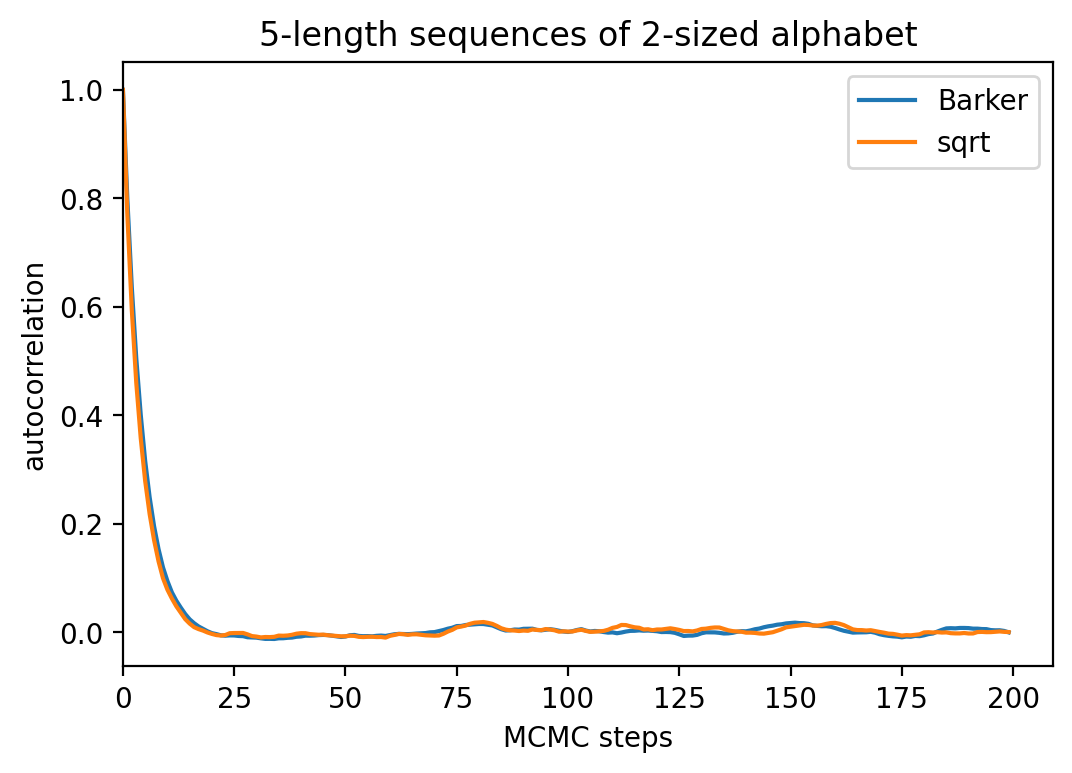

In [17]:
plot_autocorrelation(5, 2)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

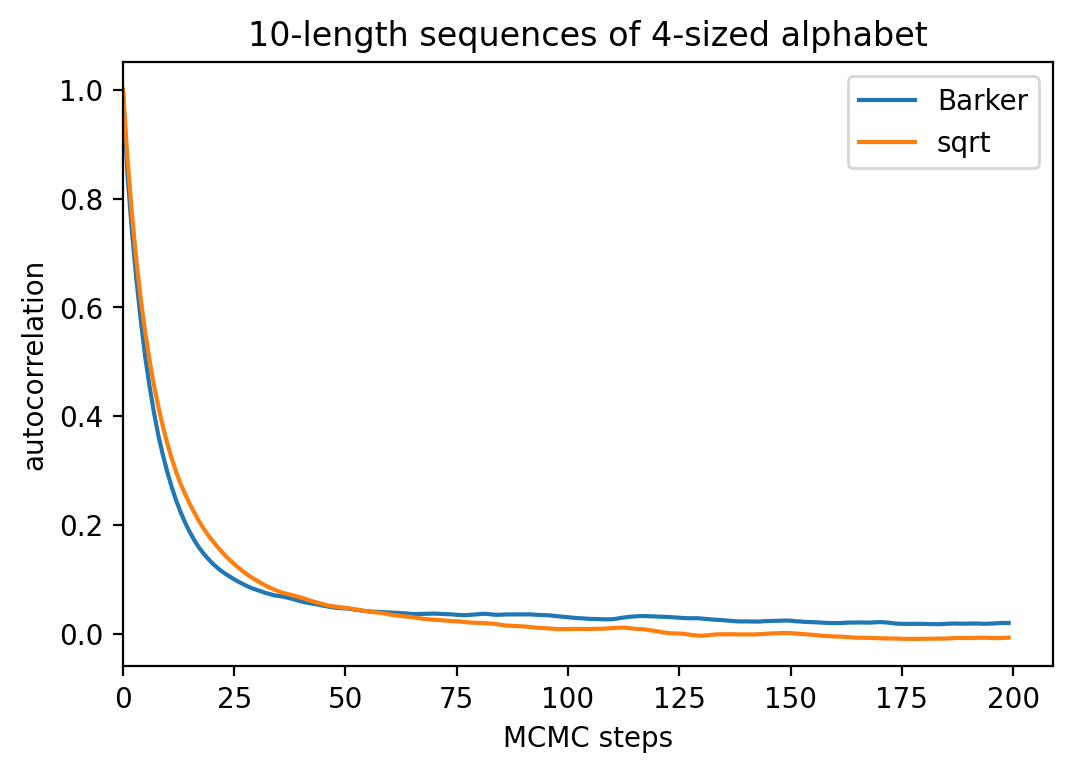

In [18]:
plot_autocorrelation(10, 4)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

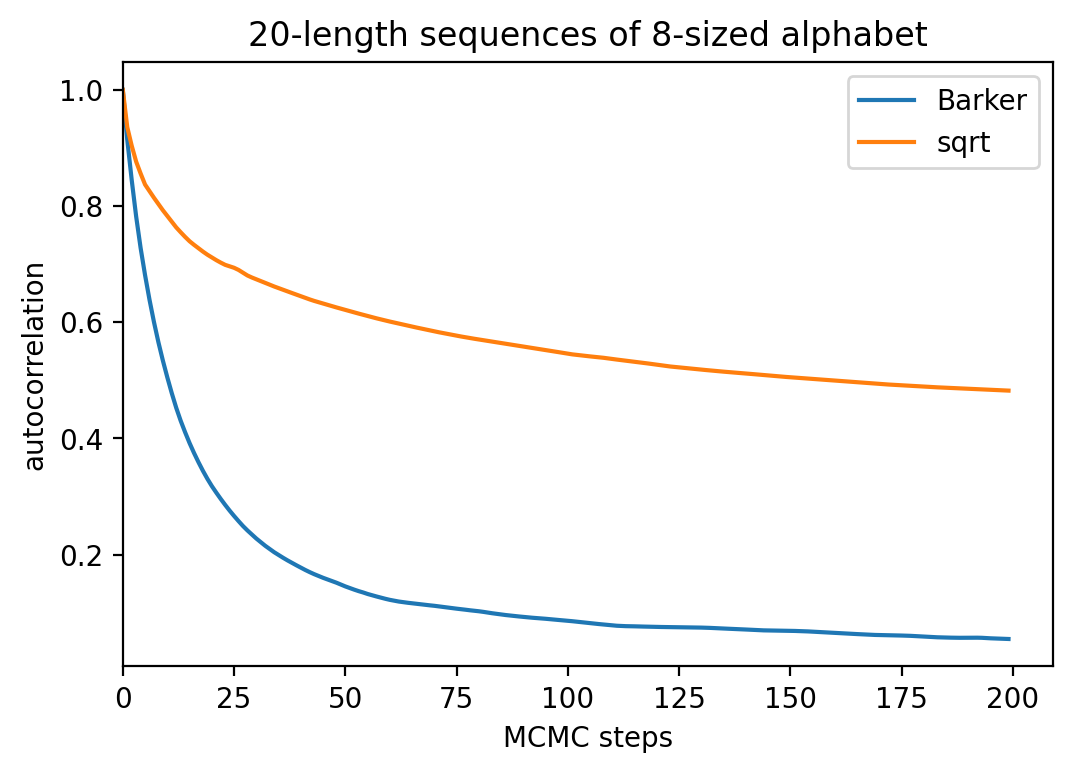

In [20]:
plot_autocorrelation(20, 8)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

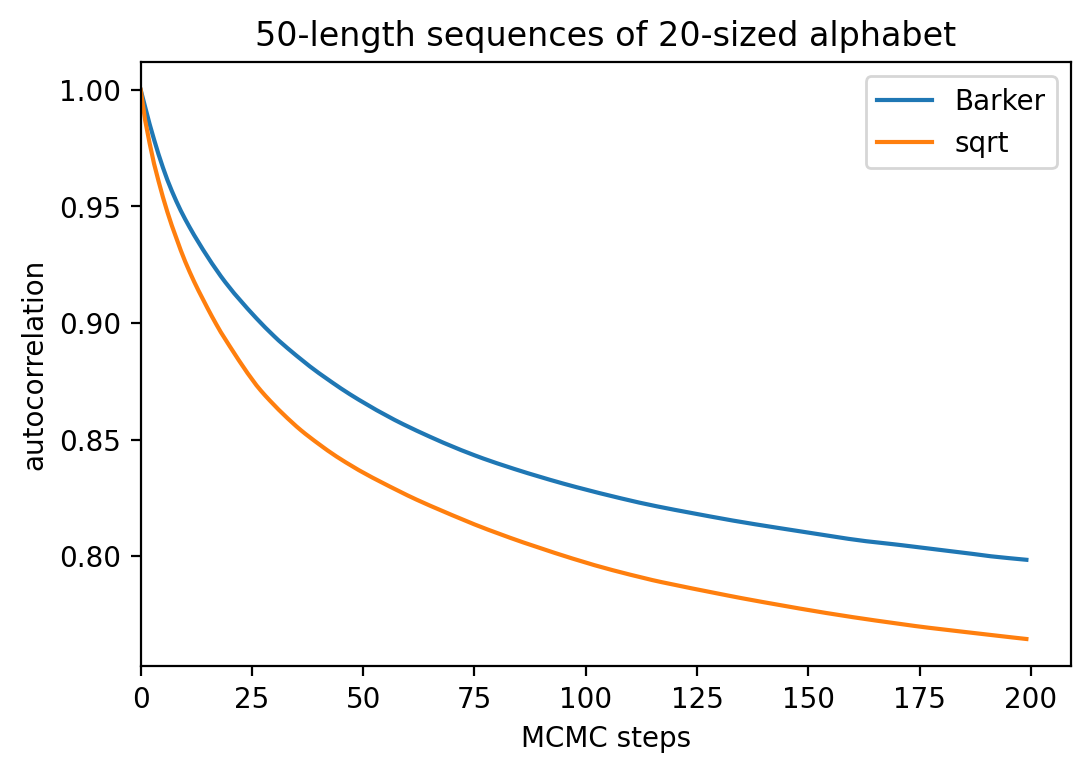

In [21]:
plot_autocorrelation(50, 20)